# X to Autosome Ratio

Here I perform a preliminary dosage compensation experiment in testis. This is a very rough preliminary analysis, but I have played with lots of different normalizations and ways of looking at things and the results are consistent. There appears to be attenuated dosage compensation in germ cells. 

In [305]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')
sns.set_context('notebook')
sns.mpl.rc("figure", figsize=(10, 10))

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-10-13 
Git hash: bd535da7ac7a1f4ef3ccae2e7674b807d504a624


In [70]:
# Get count matrix
testis = pd.read_csv('../../output/single_cell_matrix_testis.tsv', sep='\t', index_col=0)
te = testis.drop('gene_symbol', axis=1).T

In [706]:
# Get clusters
clusters = pd.read_csv('../../output/testis_clusters.tsv', sep='\t', header=None)

In [707]:
clusters.columns = ['cell', 'cluster']

,0,1
0,AAACCTGGTTCATGGT,4
1,AAACGGGAGACTGGGT,6
2,AAACGGGGTGTTAAGA,1
3,AAAGATGAGTATCGAA,6
4,AAAGCAAGTCTAGGTT,3
5,AAATGCCGTAAAGGAG,2
6,AACCATGCAGTACACT,2
7,AACCGCGCAGCGTCCA,1
8,AACGTTGAGTACCGGA,2
9,AACTCAGAGAGTAATC,1


In [71]:
# Make look up tables
fbgn2symbol = testis['gene_symbol'].to_dict()
symbol2fbgn = {}
for k, v in fbgn2symbol.items():
    symbol2fbgn[v] = k

In [687]:
# Genes need to be expressed in 1/3 of samples.
expressed = (te > 0).sum() > te.shape[0] / 3

In [688]:
# make fbgn2chrom
REF = os.environ['REFERENCES_DIR']
CHROMS = ['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4']

genes = []
with open(os.path.join(REF, 'dmel/r6-11/gtf/dmel_r6-11.gtf')) as fh:
    for row in fh:
        rows = row.strip().split()
        
        if len(rows) == 0:
            continue
            
        if rows[2] == 'gene':
            genes.append((rows[0], rows[9].replace('"', '').replace(';', '')))

fbgn2chrom = pd.DataFrame(genes, columns=['chrom', 'FBgn'])
fbgn2chrom.set_index('FBgn', inplace=True)
fbgn2chrom = fbgn2chrom[fbgn2chrom['chrom'].isin(CHROMS)]

In [689]:
# germ cells
germ = te[te[symbol2fbgn['vas']] > 0].T

# somatic cells
soma = te[te[symbol2fbgn['dsx']] > 0].T

# normalize
def libnorm(df):
    df2 = df[expressed].copy()
    return np.log2(df2 / df2.sum() * 10**4 + 1)

germ_rpm = libnorm(germ)
soma_rpm = libnorm(soma)

In [690]:
# Aggregate across samples
def agg_samples(df, aggfunc=np.median):
    med = df.apply(aggfunc, axis=1).to_frame()
    merged = med.join(fbgn2chrom, how='inner').set_index('chrom', append=True)
    merged.sort_index(inplace=True)
    merged.columns = ['med_rpm']
    return merged

germ_rpm_smed = agg_samples(germ_rpm, aggfunc=np.median)
soma_rpm_smed = agg_samples(soma_rpm, aggfunc=np.median)

In [691]:
# Center samples using X chrom
def median_center(df):
    return df - df.loc[(slice(None), 'chrX'), :].median()

germ_rpm_scaled = median_center(germ_rpm_smed)
soma_rpm_scaled = median_center(soma_rpm_smed)

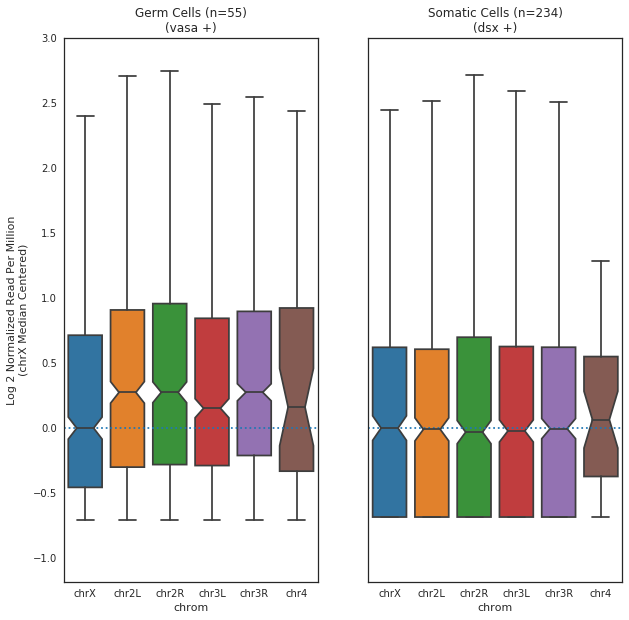

In [694]:
# Boxplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.boxplot(germ_rpm_scaled.index.get_level_values(-1), germ_rpm_scaled.med_rpm, notch=True, ax=ax1, order=CHROMS, fliersize=0)
sns.boxplot(soma_rpm_scaled.index.get_level_values(-1), soma_rpm_scaled.med_rpm, notch=True, ax=ax2, order=CHROMS, fliersize=0)

ax1.set_title('Germ Cells (n={})\n(vasa +)'.format(germ.shape[1]))
ax2.set_title('Somatic Cells (n={})\n(dsx +)'.format(soma.shape[1]))
ax1.set_ylim(None, 3)
ax1.axhline(0, ls=':')
ax2.axhline(0, ls=':')

ax1.set_ylabel('Log 2 Normalized Read Per Million\n(chrX Median Centered)')
ax2.set_ylabel('')